# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Información
names = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL']
start = '2015-01-01'

In [4]:
# Precios diarios
closes = get_adj_closes(tickers=names,
                        start_date=start)
closes.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,24.941502,41.647892,308.519989,78.449997,529.549988
2015-01-05,24.238857,41.264908,302.190002,77.190002,519.460022
2015-01-06,24.241146,40.659245,295.290009,76.150002,506.640015
2015-01-07,24.581060,41.175831,298.420013,76.150002,505.149994
2015-01-08,25.525522,42.387146,300.459991,78.180000,506.910004


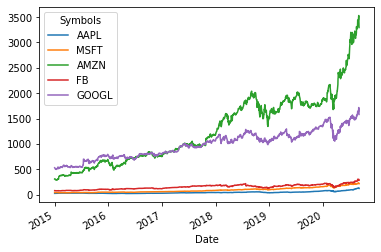

In [5]:
# Gráfico de histórico de precios diarios
closes.plot()

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [6]:
# Método shift() de un DataFrame...
help(closes.shift)

Help on method shift in module pandas.core.frame:

shift(periods=1, freq=None, axis=0, fill_value=None) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Shift index by desired number of periods with an optional time `freq`.
    
    When `freq` is not passed, shift the index without realigning the data.
    If `freq` is passed (in this case, the index must be date or datetime,
    or it will raise a `NotImplementedError`), the index will be
    increased using the periods and the `freq`.
    
    Parameters
    ----------
    periods : int
        Number of periods to shift. Can be positive or negative.
    freq : DateOffset, tseries.offsets, timedelta, or str, optional
        Offset to use from the tseries module or time rule (e.g. 'EOM').
        If `freq` is specified then the index values are shifted but the
        data is not realigned. That is, use `freq` if you would like to
        extend the index when shifting and preserve the original data.
    axis : {0 o

In [7]:
closes.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,24.941502,41.647892,308.519989,78.449997,529.549988
2015-01-05,24.238857,41.264908,302.190002,77.190002,519.460022
2015-01-06,24.241146,40.659245,295.290009,76.150002,506.640015
2015-01-07,24.581060,41.175831,298.420013,76.150002,505.149994
2015-01-08,25.525522,42.387146,300.459991,78.180000,506.910004


In [8]:
closes.shift().head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,24.941502,41.647892,308.519989,78.449997,529.549988
2015-01-06,24.238857,41.264908,302.190002,77.190002,519.460022
2015-01-07,24.241146,40.659245,295.290009,76.150002,506.640015
2015-01-08,24.581060,41.175831,298.420013,76.150002,505.149994


In [10]:
# Calcular los rendimientos
ret = ((closes - closes.shift()) / closes.shift()).dropna()
ret.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.028172,-0.009196,-0.020517,-0.016061,-0.019054
2015-01-06,0.000094,-0.014677,-0.022833,-0.013473,-0.024679
2015-01-07,0.014022,0.012705,0.010600,0.000000,-0.002941
2015-01-08,0.038422,0.029418,0.006836,0.026658,0.003484
2015-01-09,0.001072,-0.008405,-0.011749,-0.005628,-0.012211


In [12]:
# Otra forma (más fácil)
ret = closes.pct_change().dropna()
ret.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.028172,-0.009196,-0.020517,-0.016061,-0.019054
2015-01-06,0.000094,-0.014677,-0.022833,-0.013473,-0.024679
2015-01-07,0.014022,0.012705,0.010600,0.000000,-0.002941
2015-01-08,0.038422,0.029418,0.006836,0.026658,0.003484
2015-01-09,0.001072,-0.008405,-0.011749,-0.005628,-0.012211


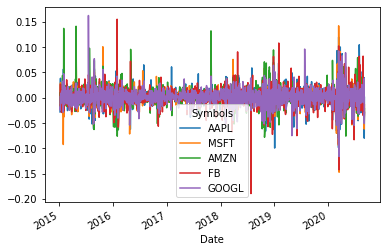

In [13]:
# Graficar...
ret.plot()

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [14]:
# Calcular rendimientos continuamente compuestos
log_ret = np.log(closes / closes.shift()).dropna()
log_ret.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.028576,-0.009238,-0.020731,-0.016191,-0.019238
2015-01-06,0.000094,-0.014786,-0.023098,-0.013565,-0.024989
2015-01-07,0.013925,0.012625,0.010544,0.000000,-0.002945
2015-01-08,0.037703,0.028994,0.006813,0.026309,0.003478
2015-01-09,0.001072,-0.008441,-0.011818,-0.005644,-0.012286


In [15]:
# Recordar rendimientos porcentuales. Ver que son similares
ret.head()

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.028172,-0.009196,-0.020517,-0.016061,-0.019054
2015-01-06,0.000094,-0.014677,-0.022833,-0.013473,-0.024679
2015-01-07,0.014022,0.012705,0.010600,0.000000,-0.002941
2015-01-08,0.038422,0.029418,0.006836,0.026658,0.003484
2015-01-09,0.001072,-0.008405,-0.011749,-0.005628,-0.012211


In [16]:
# Veamos el valor absoluto de la diferencia
np.abs(ret - log_ret)

Symbols,AAPL,MSFT,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,4.044360e-04,0.000043,0.000213,0.000130,0.000184
2015-01-06,4.458010e-09,0.000109,0.000265,0.000092,0.000310
2015-01-07,9.740165e-05,0.000080,0.000056,0.000000,0.000004
2015-01-08,7.197593e-04,0.000424,0.000023,0.000349,0.000006
2015-01-09,5.743993e-07,0.000036,0.000070,0.000016,0.000075
...,...,...,...,...,...
2020-08-31,5.623388e-04,0.000110,0.000103,0.000001,0.000018
2020-09-01,7.728616e-04,0.000030,0.000096,0.000029,0.000122
2020-09-02,2.176380e-04,0.000183,0.000042,0.000281,0.000691


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [17]:
# Rendimiento medio diario (media aritmética)
ret.mean()

Symbols
AAPL     0.001274
MSFT     0.001300
AMZN     0.001844
FB       0.001096
GOOGL    0.000907
dtype: float64

In [18]:
# Volatilidad diaria (desviación estándar)
ret.std()

Symbols
AAPL     0.018339
MSFT     0.017491
AMZN     0.019339
FB       0.019868
GOOGL    0.016826
dtype: float64

In [19]:
# Podemos resumir en un DataFrame
ret_summary = pd.DataFrame({'Media': ret.mean(), 'Vol': ret.std()})
ret_summary

,Media,Vol
Symbols,,
AAPL,0.001274,0.018339
MSFT,0.001300,0.017491
AMZN,0.001844,0.019339
FB,0.001096,0.019868
GOOGL,0.000907,0.016826


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [20]:
# Resumen en base anual
annual_ret_summary = pd.DataFrame({'Media': 252 * ret.mean(), 'Vol': np.sqrt(252) * ret.std()})
annual_ret_summary

,Media,Vol
Symbols,,
AAPL,0.320996,0.291129
MSFT,0.327489,0.277661
AMZN,0.464578,0.306999
FB,0.276244,0.315393
GOOGL,0.228475,0.267103


In [21]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Rendimiento esperado $E[r]$')

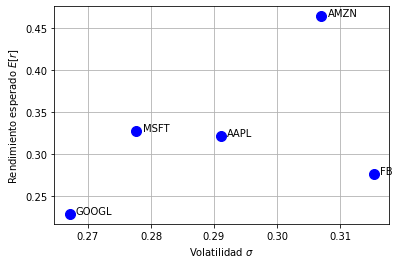

In [28]:
# Gráfico rendimiento esperado vs. volatilidad
plt.figure(figsize=(6, 4));
for i in range(len(annual_ret_summary)):
    plt.plot(annual_ret_summary.iloc[i, 1], annual_ret_summary.iloc[i, 0], 'ob', ms=10)
    plt.text(annual_ret_summary.iloc[i, 1]+0.001, annual_ret_summary.iloc[i, 0], annual_ret_summary.index[i])
    
plt.grid()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [29]:
# Importar el módulo optimize de la librería scipy
from scipy.optimize import minimize

In [30]:
# Funcion minimize
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [37]:
# Funcion objetivo y condicion inicial
def min_sq(beta, y, x):
    f_hat = beta[0] + beta[1] * x
    sum_sq = ((y - f_hat)**2).sum()
    return sum_sq

x0 = [0, 0]

In [38]:
# Resolver problema de optimizacion
resultado = minimize(fun=min_sq,
                     x0=x0,
                     args=(annual_ret_summary['Media'], annual_ret_summary['Vol'])
                    )

In [39]:
resultado

      fun: 0.024283477571292428
 hess_inv: array([[ 26.71785539, -91.26429677],
       [-91.26429677, 312.91671488]])
      jac: array([0.00000000e+00, 2.09547579e-09])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([-0.28272452,  2.07874721])

In [40]:
beta = resultado.x

Text(0, 0.5, 'Rendimiento esperado $E[r]$')

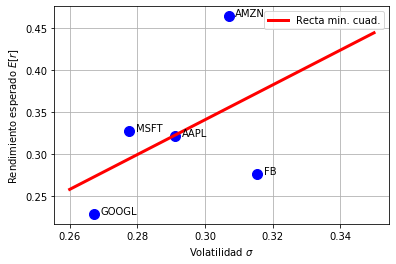

In [47]:
# Ventana para graficar
plt.figure(figsize=(6, 4));
for i in range(len(annual_ret_summary)):
    plt.plot(annual_ret_summary.iloc[i, 1], annual_ret_summary.iloc[i, 0], 'ob', ms=10)
    plt.text(annual_ret_summary.iloc[i, 1]+0.002, annual_ret_summary.iloc[i, 0], annual_ret_summary.index[i])

x = np.linspace(0.26, 0.35)
plt.plot(x, beta[0] + beta[1] * x, '-r', lw=3, label='Recta min. cuad.')
    
plt.grid()
plt.legend(loc='best')
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")

In [48]:
beta

array([-0.28272452,  2.07874721])

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- La pendiente de la recta es positiva, lo que confirma la relación positiva entre rendimiento esperado y riesgo.
- Si el mercado solo estuviera dado por los cinco activos analizados, la tasa libre de riesgo sería $-28.3\%$.
- Por cada unidad de riesgo (volatilidad), el rendimiento aumenta $200\%$.

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. 
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>